In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import shutil
import splitfolders
from keras.layers import (Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization)
from keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.backend as K
import pickle
from keras.callbacks import Callback
from cycler import cycler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Custom recall metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Custom callback for testing
class TestMetrics(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_metrics = {
            'test_loss': [],
            'test_accuracy': [],
            'test_recall_m': []
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        test_loss, test_acc, test_recall = self.model.evaluate(self.test_data, verbose=0)
        self.test_metrics['test_loss'].append(test_loss)
        self.test_metrics['test_accuracy'].append(test_acc)
        self.test_metrics['test_recall_m'].append(test_recall)
        logs['test_loss'] = test_loss
        logs['test_accuracy'] = test_acc
        logs['test_recall_m'] = test_recall

# Directory setup and data splitting
ROOT_DIR = "/content/drive/MyDrive/brain_tumor_dataset"
splitfolders.ratio(ROOT_DIR, output="splited_dataset", seed=42, ratio=(0.8, 0.1, 0.1))

# ImageDataGenerator setup
datagen = ImageDataGenerator(rescale=1/255.0)

# Function to build and compile a model
def build_compile_model(optimizer, learning_rate):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', recall_m])
    return model

# Define the batch sizes, learning rates, and optimizers
batch_sizes = [8, 16, 32]
learning_rates = {
    'Adagrad': [0.01, 0.0001, 0.002, 0.0003],
    'Adam': [0.0001, 0.0002, 0.03]
}
optimizers = {
    'Adagrad': lambda lr: keras.optimizers.Adagrad(learning_rate=lr),
    'Adam': lambda lr: keras.optimizers.Adam(learning_rate=lr)
}

# Models configurations
models_configs = [
    {"name": f"Model_{opt_name}_LR{lr}_BS{bs}", "optimizer": opt_func(lr), "batch_size": bs}
    for opt_name, opt_func in optimizers.items()
    for lr in learning_rates[opt_name]
    for bs in batch_sizes
]

# Train and save each model and its history
metrics = []

for config in models_configs:
    model = build_compile_model(config["optimizer"], config["optimizer"].learning_rate)
    print(f"Training {config['name']}")

    train_data = datagen.flow_from_directory('splited_dataset/train', target_size=(224,224), batch_size=config['batch_size'], class_mode='binary', shuffle=True)
    valid_data = datagen.flow_from_directory('splited_dataset/val', target_size=(224,224), batch_size=config['batch_size'], class_mode='binary', shuffle=True)
    test_data = datagen.flow_from_directory('splited_dataset/test', target_size=(224,224), batch_size=config['batch_size'], class_mode='binary', shuffle=False)

    test_metrics_callback = TestMetrics(test_data)

    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=20,
        verbose=1,
        callbacks=[test_metrics_callback]
    )

    model.save(f"{config['name']}.h5")

    # Save history and test metrics
    history.history.update(test_metrics_callback.test_metrics)
    with open(f"{config['name']}_history.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    # Collect metrics
    metrics.append({
        'model': config['name'],
        'test_accuracy': history.history['test_accuracy'][-1],
        'test_loss': history.history['test_loss'][-1],
        'test_recall': history.history['test_recall_m'][-1]
    })



Copying files: 253 files [01:19,  3.17 files/s]


Training Model_Adagrad_LR0.01_BS8
Found 202 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Epoch 1/20
26/26 [==============================] - 9s 89ms/step - loss: 0.6178 - accuracy: 0.6634 - recall_m: 0.7678 - val_loss: 0.4815 - val_accuracy: 0.7917 - val_recall_m: 1.0000 - test_loss: 0.5206 - test_accuracy: 0.7407 - test_recall_m: 0.7500
Epoch 2/20
26/26 [==============================] - 1s 35ms/step - loss: 0.6088 - accuracy: 0.7277 - recall_m: 0.8749 - val_loss: 0.4710 - val_accuracy: 0.8333 - val_recall_m: 0.9444 - test_loss: 0.4874 - test_accuracy: 0.8519 - test_recall_m: 0.6667
Epoch 3/20
26/26 [==============================] - 1s 29ms/step - loss: 0.5477 - accuracy: 0.7574 - recall_m: 0.8418 - val_loss: 0.4886 - val_accuracy: 0.8333 - val_recall_m: 0.8889 - test_loss: 0.4805 - test_accuracy: 0.8889 - test_recall_m: 0.6667
Epoch 4/20
26/26 [==============================] - 1s 30ms/step - loss: 0.5110 - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Model_Adagrad_LR0.01_BS16
Found 202 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Epoch 1/20
13/13 [==============================] - 4s 158ms/step - loss: 0.6486 - accuracy: 0.6238 - recall_m: 0.8971 - val_loss: 0.5390 - val_accuracy: 0.8333 - val_recall_m: 1.0000 - test_loss: 0.5494 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 2/20
13/13 [==============================] - 1s 68ms/step - loss: 0.5738 - accuracy: 0.7129 - recall_m: 0.8785 - val_loss: 0.4612 - val_accuracy: 0.8333 - val_recall_m: 1.0000 - test_loss: 0.5246 - test_accuracy: 0.8148 - test_recall_m: 1.0000
Epoch 3/20
13/13 [==============================] - 1s 65ms/step - loss: 0.5533 - accuracy: 0.7327 - recall_m: 0.8614 - val_loss: 0.4261 - val_accuracy: 0.8333 - val_recall_m: 0.9545 - test_loss: 0.4682 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 4/20
13/13 [==============================] - 1s 65ms/step - loss: 0.5573 - accuracy

13/13 [==============================] - 2s 76ms/step - loss: 0.7024 - accuracy: 0.4604 - recall_m: 0.2557 - val_loss: 0.6892 - val_accuracy: 0.5000 - val_recall_m: 0.3500 - test_loss: 0.6863 - test_accuracy: 0.5926 - test_recall_m: 0.6727
Epoch 2/20
13/13 [==============================] - 1s 68ms/step - loss: 0.6826 - accuracy: 0.5594 - recall_m: 0.6648 - val_loss: 0.6702 - val_accuracy: 0.6667 - val_recall_m: 1.0000 - test_loss: 0.6679 - test_accuracy: 0.7037 - test_recall_m: 1.0000
Epoch 3/20
13/13 [==============================] - 1s 59ms/step - loss: 0.6612 - accuracy: 0.6782 - recall_m: 0.9827 - val_loss: 0.6542 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6535 - test_accuracy: 0.6296 - test_recall_m: 1.0000
Epoch 4/20
13/13 [==============================] - 1s 61ms/step - loss: 0.6551 - accuracy: 0.6436 - recall_m: 0.9665 - val_loss: 0.6428 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6429 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 5

7/7 [==============================] - 2s 189ms/step - loss: 0.6975 - accuracy: 0.4604 - recall_m: 0.3608 - val_loss: 0.6974 - val_accuracy: 0.3333 - val_recall_m: 0.4000 - test_loss: 0.6980 - test_accuracy: 0.3333 - test_recall_m: 0.5000
Epoch 2/20
7/7 [==============================] - 1s 189ms/step - loss: 0.6930 - accuracy: 0.4901 - recall_m: 0.5924 - val_loss: 0.6906 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6918 - test_accuracy: 0.5556 - test_recall_m: 0.9375
Epoch 3/20
7/7 [==============================] - 1s 121ms/step - loss: 0.6855 - accuracy: 0.5644 - recall_m: 0.8378 - val_loss: 0.6860 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6877 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 4/20
7/7 [==============================] - 1s 128ms/step - loss: 0.6809 - accuracy: 0.5891 - recall_m: 0.8569 - val_loss: 0.6802 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6825 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 5/20


13/13 [==============================] - 2s 77ms/step - loss: 0.6654 - accuracy: 0.5941 - recall_m: 0.9250 - val_loss: 0.6259 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6333 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
13/13 [==============================] - 1s 74ms/step - loss: 0.6368 - accuracy: 0.6139 - recall_m: 1.0000 - val_loss: 0.5926 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6011 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
13/13 [==============================] - 1s 93ms/step - loss: 0.6116 - accuracy: 0.6337 - recall_m: 1.0000 - val_loss: 0.5536 - val_accuracy: 0.7500 - val_recall_m: 1.0000 - test_loss: 0.5675 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 4/20
13/13 [==============================] - 1s 94ms/step - loss: 0.5940 - accuracy: 0.6683 - recall_m: 0.9715 - val_loss: 0.5226 - val_accuracy: 0.7917 - val_recall_m: 0.9583 - test_loss: 0.5370 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 5

7/7 [==============================] - 2s 160ms/step - loss: 0.6723 - accuracy: 0.6337 - recall_m: 0.8780 - val_loss: 0.6286 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6320 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
7/7 [==============================] - 1s 127ms/step - loss: 0.6355 - accuracy: 0.6188 - recall_m: 1.0000 - val_loss: 0.5973 - val_accuracy: 0.6667 - val_recall_m: 1.0000 - test_loss: 0.6011 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
7/7 [==============================] - 1s 136ms/step - loss: 0.6096 - accuracy: 0.6485 - recall_m: 1.0000 - val_loss: 0.5607 - val_accuracy: 0.7500 - val_recall_m: 1.0000 - test_loss: 0.5698 - test_accuracy: 0.6667 - test_recall_m: 1.0000
Epoch 4/20
7/7 [==============================] - 1s 124ms/step - loss: 0.5951 - accuracy: 0.6634 - recall_m: 0.9788 - val_loss: 0.5370 - val_accuracy: 0.6667 - val_recall_m: 1.0000 - test_loss: 0.5542 - test_accuracy: 0.6296 - test_recall_m: 1.0000
Epoch 5/20


13/13 [==============================] - 3s 103ms/step - loss: 0.6770 - accuracy: 0.5792 - recall_m: 0.8780 - val_loss: 0.6553 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6517 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
13/13 [==============================] - 1s 66ms/step - loss: 0.6552 - accuracy: 0.6139 - recall_m: 1.0000 - val_loss: 0.6352 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6335 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
13/13 [==============================] - 1s 62ms/step - loss: 0.6379 - accuracy: 0.6188 - recall_m: 1.0000 - val_loss: 0.6194 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6198 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 4/20
13/13 [==============================] - 1s 68ms/step - loss: 0.6256 - accuracy: 0.6188 - recall_m: 1.0000 - val_loss: 0.6060 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6084 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 

7/7 [==============================] - 2s 167ms/step - loss: 0.6883 - accuracy: 0.5743 - recall_m: 0.5985 - val_loss: 0.6831 - val_accuracy: 0.6667 - val_recall_m: 0.9333 - test_loss: 0.6814 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
7/7 [==============================] - 1s 188ms/step - loss: 0.6771 - accuracy: 0.6238 - recall_m: 0.8910 - val_loss: 0.6713 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6706 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
7/7 [==============================] - 1s 142ms/step - loss: 0.6733 - accuracy: 0.6287 - recall_m: 1.0000 - val_loss: 0.6618 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6620 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 4/20
7/7 [==============================] - 1s 132ms/step - loss: 0.6681 - accuracy: 0.6139 - recall_m: 0.9864 - val_loss: 0.6548 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6556 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 5/20


13/13 [==============================] - 3s 84ms/step - loss: 0.6741 - accuracy: 0.6485 - recall_m: 0.9125 - val_loss: 0.5094 - val_accuracy: 0.8333 - val_recall_m: 1.0000 - test_loss: 0.5322 - test_accuracy: 0.8148 - test_recall_m: 1.0000
Epoch 2/20
13/13 [==============================] - 1s 78ms/step - loss: 0.5696 - accuracy: 0.7426 - recall_m: 0.9167 - val_loss: 0.4658 - val_accuracy: 0.7917 - val_recall_m: 0.7321 - test_loss: 0.4759 - test_accuracy: 0.7778 - test_recall_m: 0.7636
Epoch 3/20
13/13 [==============================] - 1s 89ms/step - loss: 0.5284 - accuracy: 0.7673 - recall_m: 0.8932 - val_loss: 0.4032 - val_accuracy: 0.8750 - val_recall_m: 0.9000 - test_loss: 0.4232 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 4/20
13/13 [==============================] - 1s 94ms/step - loss: 0.5038 - accuracy: 0.8168 - recall_m: 0.8823 - val_loss: 0.3955 - val_accuracy: 0.8333 - val_recall_m: 0.8500 - test_loss: 0.3903 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 5

7/7 [==============================] - 3s 160ms/step - loss: 0.6212 - accuracy: 0.6485 - recall_m: 0.8603 - val_loss: 0.4383 - val_accuracy: 0.8333 - val_recall_m: 0.9333 - test_loss: 0.4862 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 2/20
7/7 [==============================] - 1s 123ms/step - loss: 0.5380 - accuracy: 0.7376 - recall_m: 0.7888 - val_loss: 0.4029 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.4335 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 3/20
7/7 [==============================] - 1s 131ms/step - loss: 0.5148 - accuracy: 0.7921 - recall_m: 0.8791 - val_loss: 0.3857 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.4051 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 4/20
7/7 [==============================] - 1s 168ms/step - loss: 0.4847 - accuracy: 0.8168 - recall_m: 0.8950 - val_loss: 0.3779 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.3903 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 5/20


26/26 [==============================] - 3s 41ms/step - loss: 0.6376 - accuracy: 0.6584 - recall_m: 0.7998 - val_loss: 0.4893 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.4824 - test_accuracy: 0.8519 - test_recall_m: 0.6667
Epoch 2/20
26/26 [==============================] - 1s 30ms/step - loss: 0.5071 - accuracy: 0.7970 - recall_m: 0.9044 - val_loss: 0.3627 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.3766 - test_accuracy: 0.8519 - test_recall_m: 0.6667
Epoch 3/20
26/26 [==============================] - 1s 30ms/step - loss: 0.4533 - accuracy: 0.8119 - recall_m: 0.8590 - val_loss: 0.3646 - val_accuracy: 0.8333 - val_recall_m: 0.8778 - test_loss: 0.3247 - test_accuracy: 0.8519 - test_recall_m: 0.6667
Epoch 4/20
26/26 [==============================] - 1s 31ms/step - loss: 0.4234 - accuracy: 0.8069 - recall_m: 0.8709 - val_loss: 0.3532 - val_accuracy: 0.8750 - val_recall_m: 0.9444 - test_loss: 0.3073 - test_accuracy: 0.8519 - test_recall_m: 0.6667
Epoch 5

13/13 [==============================] - 3s 79ms/step - loss: 0.6023 - accuracy: 0.6634 - recall_m: 0.7076 - val_loss: 0.4488 - val_accuracy: 0.8333 - val_recall_m: 1.0000 - test_loss: 0.5206 - test_accuracy: 0.8148 - test_recall_m: 1.0000
Epoch 2/20
13/13 [==============================] - 1s 61ms/step - loss: 0.5708 - accuracy: 0.7376 - recall_m: 0.8955 - val_loss: 0.4460 - val_accuracy: 0.8333 - val_recall_m: 0.8611 - test_loss: 0.4230 - test_accuracy: 0.8889 - test_recall_m: 0.9545
Epoch 3/20
13/13 [==============================] - 1s 63ms/step - loss: 0.5061 - accuracy: 0.7822 - recall_m: 0.8678 - val_loss: 0.3662 - val_accuracy: 0.8750 - val_recall_m: 0.9444 - test_loss: 0.3669 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 4/20
13/13 [==============================] - 1s 65ms/step - loss: 0.4613 - accuracy: 0.8267 - recall_m: 0.8855 - val_loss: 0.3803 - val_accuracy: 0.8750 - val_recall_m: 0.9375 - test_loss: 0.3554 - test_accuracy: 0.8519 - test_recall_m: 0.9545
Epoch 5

7/7 [==============================] - 3s 158ms/step - loss: 0.7328 - accuracy: 0.6188 - recall_m: 0.7236 - val_loss: 0.6247 - val_accuracy: 0.7500 - val_recall_m: 0.6000 - test_loss: 0.6211 - test_accuracy: 0.7037 - test_recall_m: 0.6250
Epoch 2/20
7/7 [==============================] - 1s 131ms/step - loss: 0.6080 - accuracy: 0.6881 - recall_m: 0.7997 - val_loss: 0.4881 - val_accuracy: 0.7917 - val_recall_m: 0.9333 - test_loss: 0.5091 - test_accuracy: 0.8148 - test_recall_m: 1.0000
Epoch 3/20
7/7 [==============================] - 1s 131ms/step - loss: 0.5429 - accuracy: 0.7822 - recall_m: 0.9438 - val_loss: 0.4407 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.4604 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 4/20
7/7 [==============================] - 1s 123ms/step - loss: 0.5073 - accuracy: 0.7871 - recall_m: 0.7949 - val_loss: 0.4068 - val_accuracy: 0.8750 - val_recall_m: 0.9333 - test_loss: 0.4321 - test_accuracy: 0.8519 - test_recall_m: 0.9375
Epoch 5/20


13/13 [==============================] - 3s 83ms/step - loss: 447.0787 - accuracy: 0.5842 - recall_m: 0.6446 - val_loss: 0.6742 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6802 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
13/13 [==============================] - 1s 61ms/step - loss: 0.6723 - accuracy: 0.6139 - recall_m: 1.0000 - val_loss: 0.6616 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6783 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
13/13 [==============================] - 1s 60ms/step - loss: 0.6651 - accuracy: 0.6139 - recall_m: 1.0000 - val_loss: 0.6616 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6788 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 4/20
13/13 [==============================] - 1s 61ms/step - loss: 0.6717 - accuracy: 0.6139 - recall_m: 1.0000 - val_loss: 0.6618 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6770 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch

7/7 [==============================] - 3s 159ms/step - loss: 867.8878 - accuracy: 0.5248 - recall_m: 0.4240 - val_loss: 5.4327 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 5.9615 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 2/20
7/7 [==============================] - 1s 152ms/step - loss: 1.9525 - accuracy: 0.5891 - recall_m: 0.7172 - val_loss: 1.6171 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 1.7587 - test_accuracy: 0.5926 - test_recall_m: 1.0000
Epoch 3/20
7/7 [==============================] - 1s 124ms/step - loss: 1.3176 - accuracy: 0.4851 - recall_m: 0.6402 - val_loss: 0.7090 - val_accuracy: 0.3750 - val_recall_m: 0.0000e+00 - test_loss: 0.7054 - test_accuracy: 0.4074 - test_recall_m: 0.0000e+00
Epoch 4/20
7/7 [==============================] - 1s 158ms/step - loss: 0.6934 - accuracy: 0.5297 - recall_m: 0.6739 - val_loss: 0.6772 - val_accuracy: 0.6250 - val_recall_m: 1.0000 - test_loss: 0.6821 - test_accuracy: 0.5926 - test_recall_m: 1.0000
E

<ipython-input-5-3c6fb5ffed85>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_bs = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(batch_sizes)))


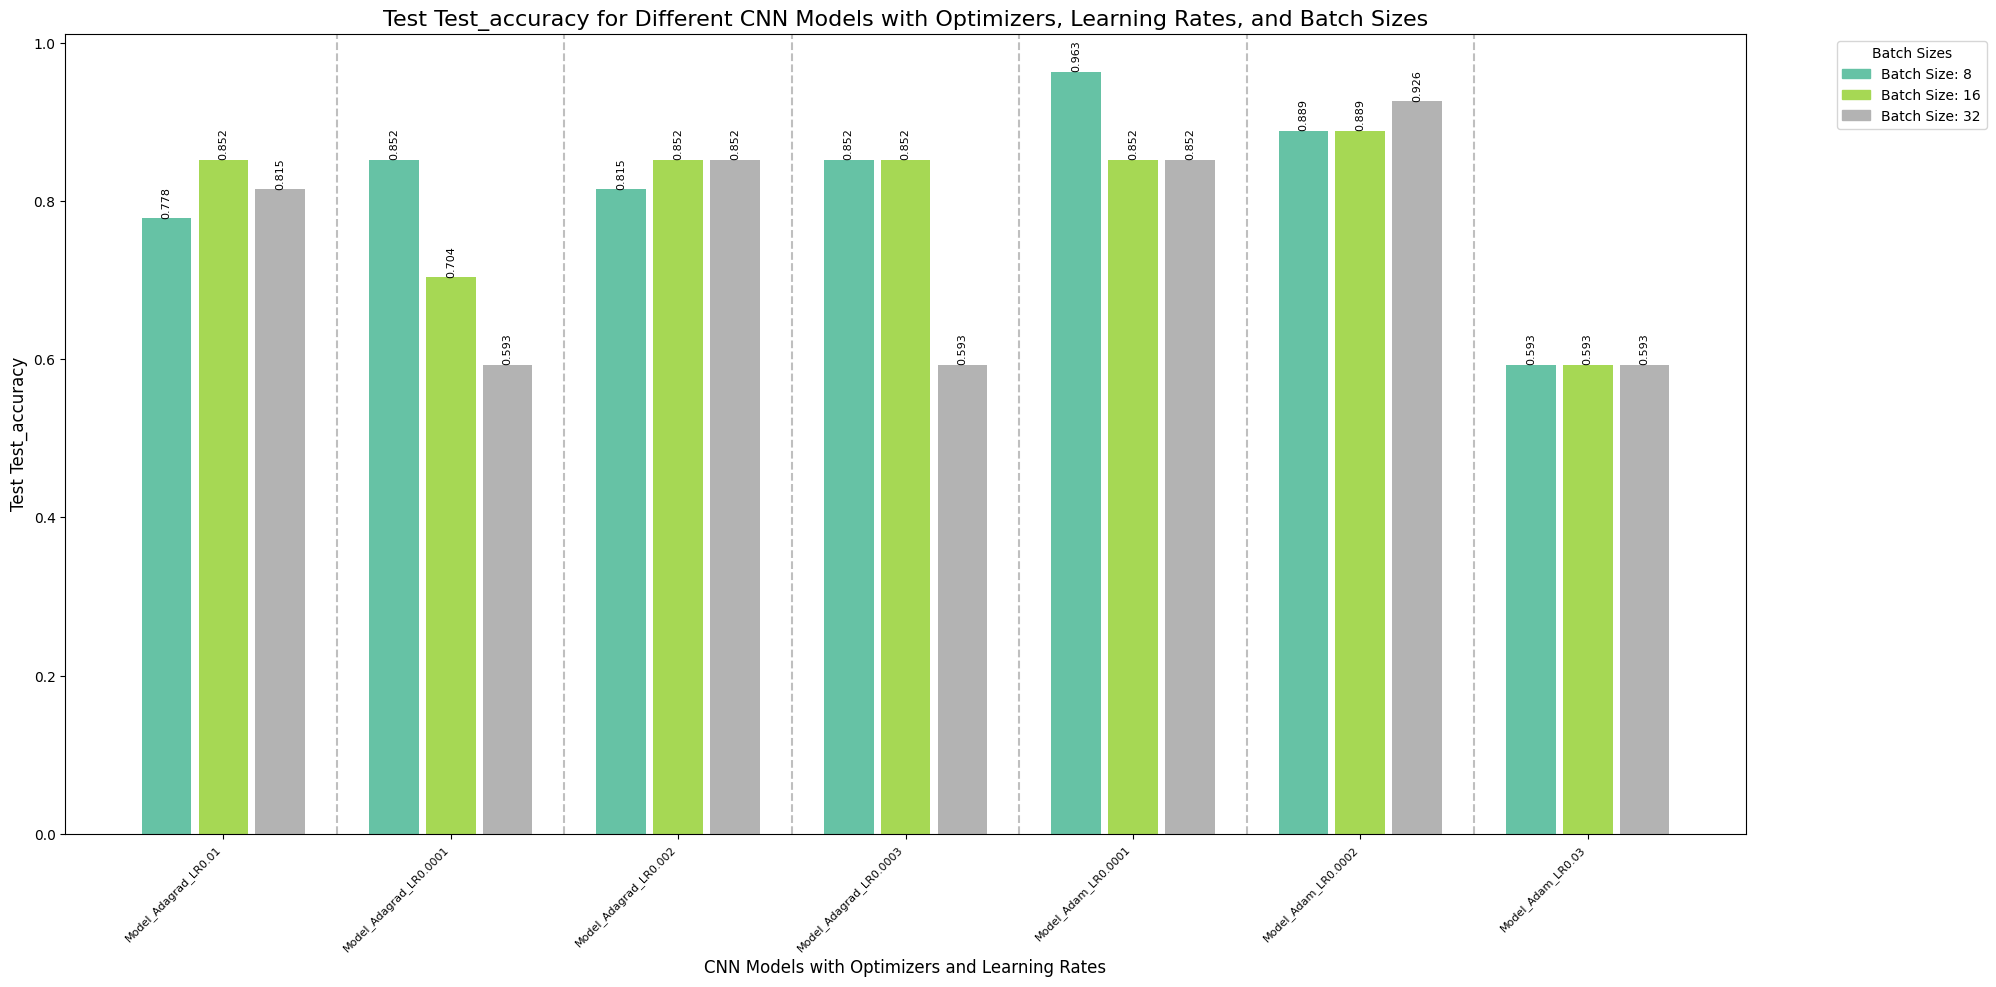

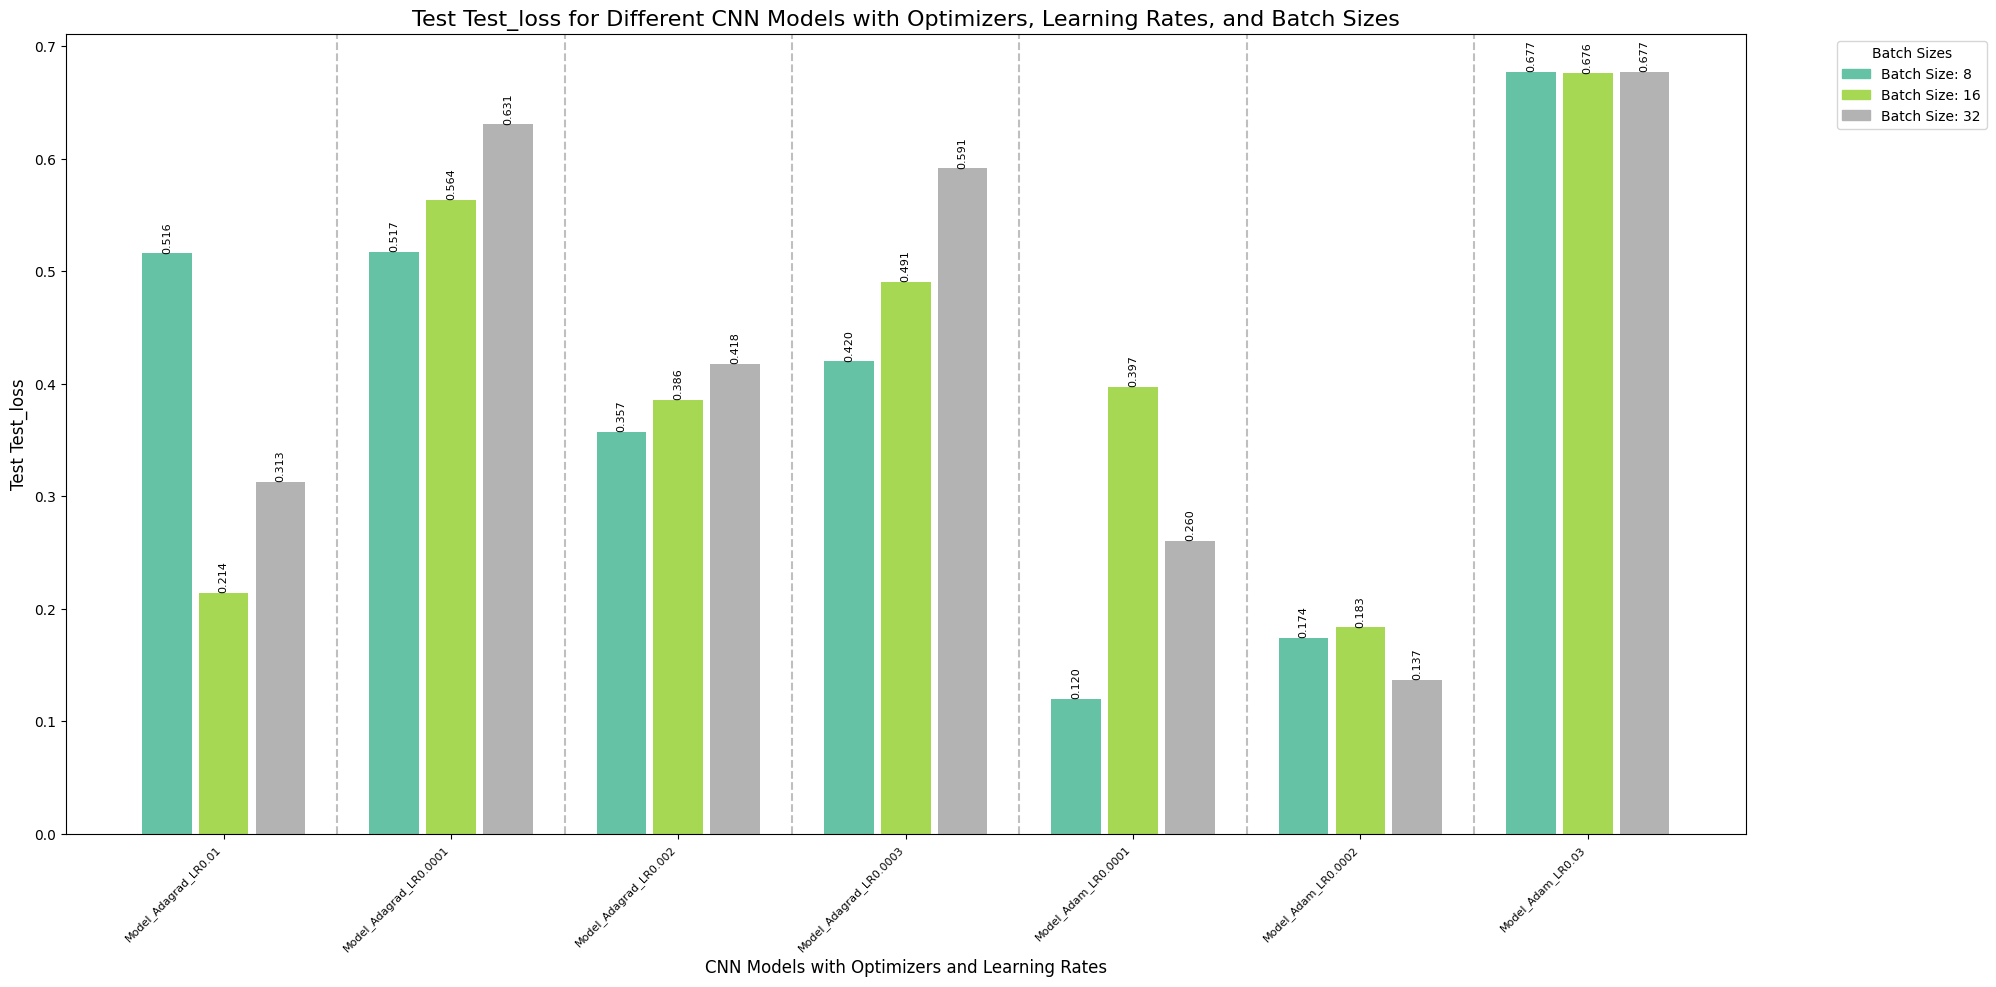

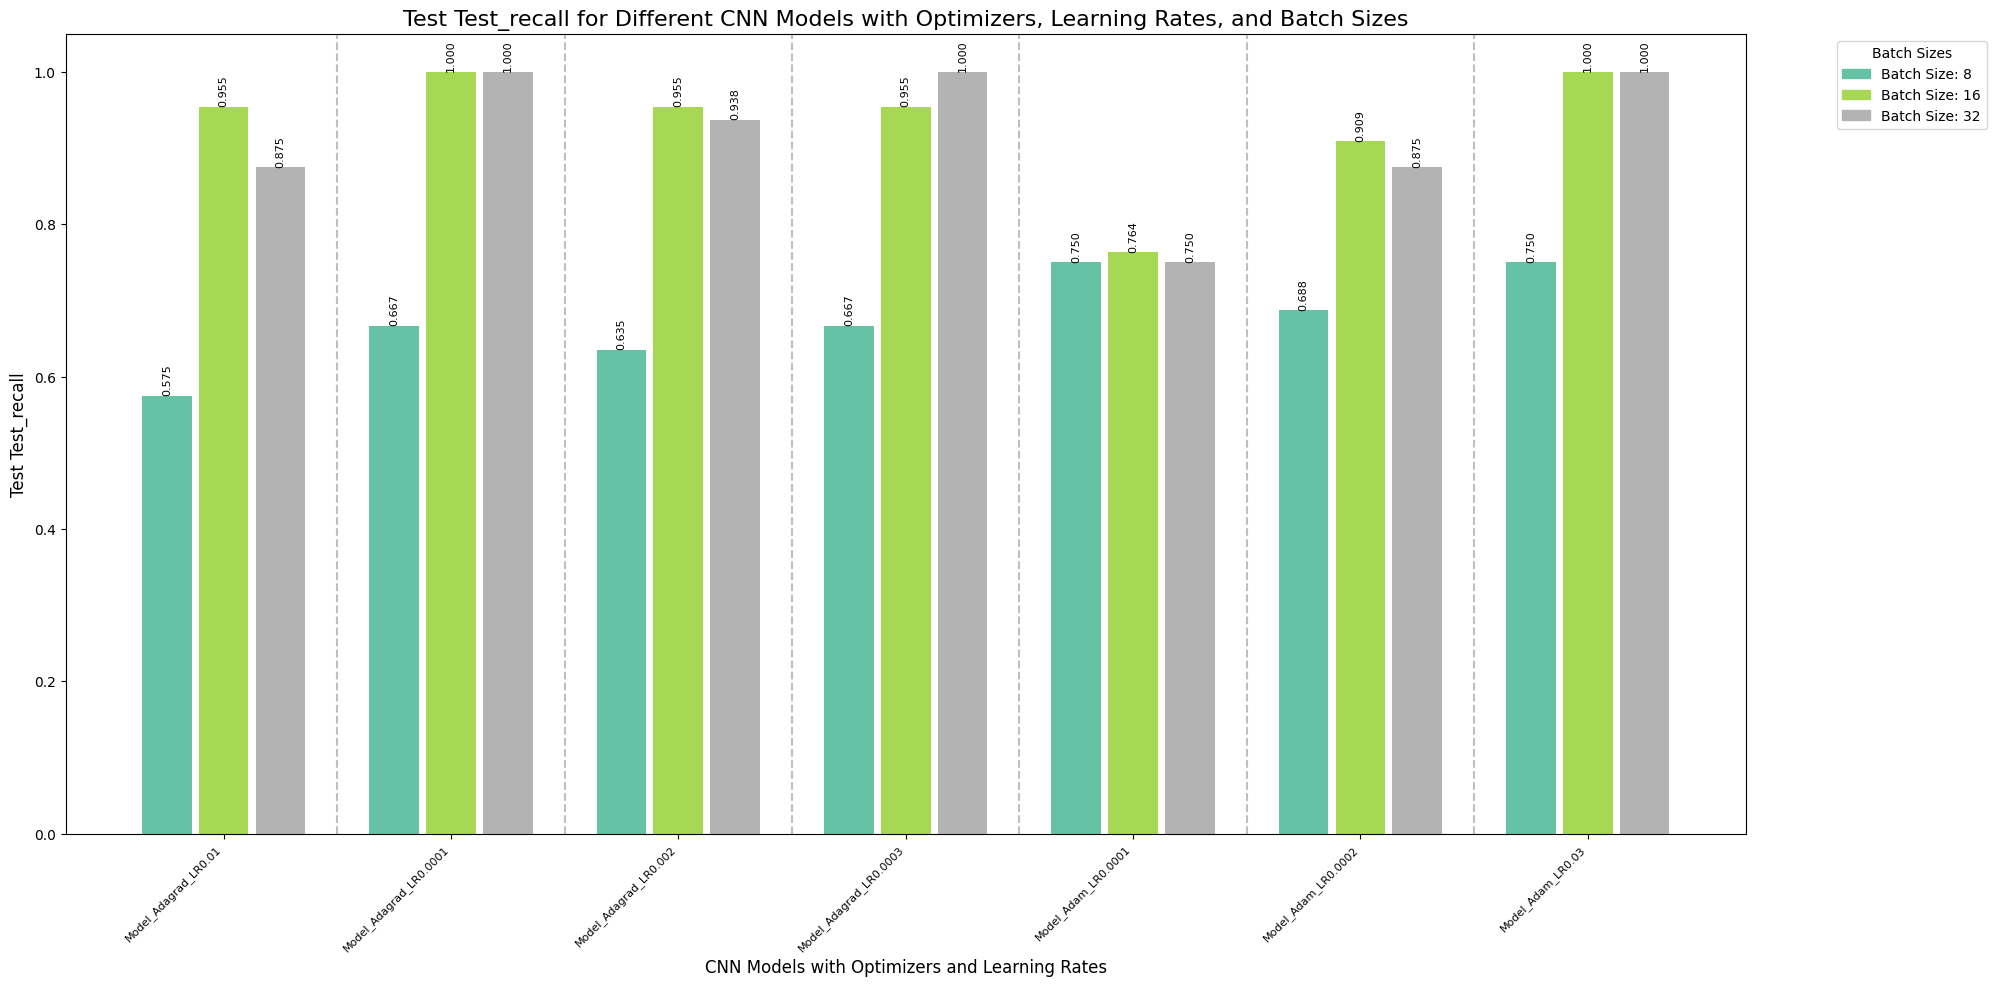

In [ ]:
# Create DataFrame from metrics
metrics_df = pd.DataFrame(metrics)

# Extract data for bar plots
bar_data = metrics_df.melt(id_vars='model', value_vars=['test_accuracy', 'test_loss', 'test_recall'], var_name='metric', value_name='value')

# Define a color map for batch sizes
color_map_bs = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(batch_sizes)))
bs_color_dict = dict(zip(batch_sizes, color_map_bs))

# Function to get color based on batch size
def get_color(model_name):
    for bs in batch_sizes:
        if f"BS{bs}" in model_name:
            return bs_color_dict[bs]
    return 'gray'  # Default color if no matching batch size is found

# Function to define the position of each bar
def get_bar_position(i, num_batch_sizes, num_groups):
    group = i // num_batch_sizes
    position_in_group = i % num_batch_sizes
    group_width = num_batch_sizes * 0.8  # Width of each group of bars
    gap = 0.8  # Gap between groups
    return group * (group_width + gap) + position_in_group * 0.8

# Plot bar plots
for metric in ['test_accuracy', 'test_loss', 'test_recall']:
    plt.figure(figsize=(20, 10))  # Adjusted figure width

    data = bar_data[bar_data['metric'] == metric]
    total_bars = len(data)
    num_batch_sizes = len(batch_sizes)
    num_groups = total_bars // num_batch_sizes

    # Create custom positions for the bars
    positions = [get_bar_position(i, num_batch_sizes, num_groups) for i in range(total_bars)]

    # Plot bars
    bars = plt.bar(positions, data['value'], color=[get_color(m) for m in data['model']], width=0.7)

    # Customize x-axis
    group_centers = [get_bar_position(i * num_batch_sizes, num_batch_sizes, num_groups) + (num_batch_sizes - 1) * 0.4 for i in range(num_groups)]
    plt.xticks(group_centers,
               [m.split('_BS')[0] for m in data['model'][::num_batch_sizes]],
               rotation=45, ha='right', fontsize=8)

    metric_title = ' '.join(word.capitalize() for word in f'Test {metric}'.split())

    plt.title(f'{metric_title} for Different CNN Models with Optimizers, Learning Rates, and Batch Sizes', fontsize=16)
    plt.ylabel(metric_title, fontsize=12)
    plt.xlabel('CNN Models with Optimizers and Learning Rates', fontsize=12)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', rotation=90, fontsize=8)

    # Add legend for batch sizes
    handles_bs = [plt.Rectangle((0,0),1,1, color=bs_color_dict[bs]) for bs in batch_sizes]
    plt.legend(handles_bs, [f'Batch Size: {bs}' for bs in batch_sizes],
               title='Batch Sizes',
               bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Add vertical lines to separate configuration groups
    for i in range(1, num_groups):
        x_position = (group_centers[i-1] + group_centers[i]) / 2
        plt.axvline(x=x_position, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.15)  # Adjusted bottom margin for labels
    plt.show()

In [ ]:
import plotly.graph_objects as go
import pickle
import pandas as pd
import plotly.express as px

# Function to load history data
def load_history(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Function to create an interactive line plot for a single metric
def create_interactive_line_plot(models_configs, metric, title, y_axis_title):
    fig = go.Figure()

    # Color scale for different configurations
    color_scale = px.colors.qualitative.Plotly

    for i, config in enumerate(models_configs):
        history = load_history(f"{config['name']}_history.pkl")
        color = color_scale[i % len(color_scale)]

        fig.add_trace(
            go.Scatter(x=list(range(1, len(history[metric])+1)),
                       y=history[metric],
                       mode='lines+markers',
                       name=f"{config['name']}",
                       line=dict(color=color))
        )

    # Update layout
    fig.update_layout(
        height=600, width=1000,
        title_text=title,
        title_x=0.5,  # Center the title
        xaxis_title="Epochs",
        yaxis_title=y_axis_title,
        yaxis=dict(range=[0, 1.2]),
        legend_title="Model Configurations",
        legend=dict(groupclick="toggleitem")
    )

    return fig

# Assuming models_configs is defined as before
models_configs = [
    {"name": f"Model_{opt_name}_LR{lr}_BS{bs}", "optimizer": opt_func(lr), "batch_size": bs}
    for opt_name, opt_func in optimizers.items()
    for lr in learning_rates[opt_name]
    for bs in batch_sizes
]

# Create and show the interactive plots
fig_accuracy = create_interactive_line_plot(models_configs, 'test_accuracy', "Test Accuracy Over Epochs for Different CNN Models", "Accuracy")
fig_accuracy.show()

fig_loss = create_interactive_line_plot(models_configs, 'test_loss', "Test Loss Over Epochs for Different CNN Models", "Loss")
fig_loss.show()

fig_recall = create_interactive_line_plot(models_configs, 'test_recall_m', "Test Recall Over Epochs for Different CNN Models", "Recall")
fig_recall.show()

In [1]:
pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jz9o1vdd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jz9o1vdd
  Resolved https://github.com/facebookresearch/detectron2.git to commit 31bebdea147c96f8a00a0d55931858bf727ae370
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [ ]:
import detectron2

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import torch

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import uuid
import sqlite3
import clip


[08/04 18:05:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


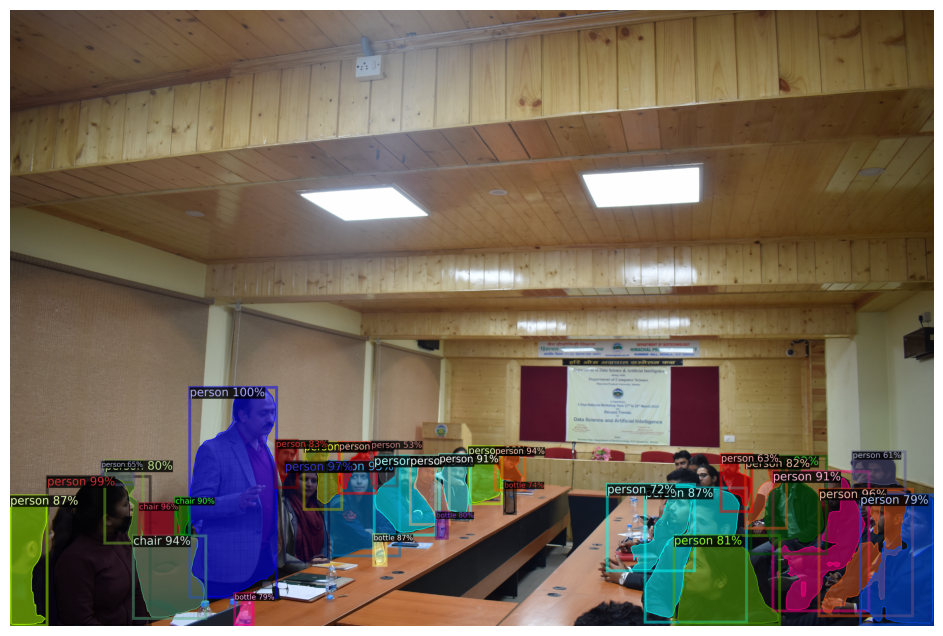

Processed image with master ID: 30562858-148d-4aa8-a3b3-2ae1b13638d9
Extracted and identified 33 objects.
Object descriptions saved to 'object_descriptions.txt'


In [ ]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import uuid
import sqlite3

# Explicit import for CLIP
import clip
from clip.clip import load as clip_load

def load_image(image_path):
    """Load an image from file."""
    return cv2.imread(image_path)

def setup_model():
    """Set up the Mask R-CNN model."""
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    return DefaultPredictor(cfg)

def segment_image(predictor, image):
    """Perform instance segmentation on the image."""
    return predictor(image)

def visualize_segmentation(image, outputs, predictor):
    """Visualize the segmentation results."""
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(predictor.cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return out.get_image()[:, :, ::-1]

def extract_objects(image, outputs):
    """Extract each segmented object from the image."""
    masks = outputs["instances"].pred_masks.cpu().numpy()
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    classes = outputs["instances"].pred_classes.cpu().numpy()

    extracted_objects = []
    for i, (mask, box, cls) in enumerate(zip(masks, boxes, classes)):
        x1, y1, x2, y2 = box.astype(int)
        object_image = image[y1:y2, x1:x2]
        object_mask = mask[y1:y2, x1:x2]

        # Apply the mask to the object image
        object_image = cv2.bitwise_and(object_image, object_image, mask=object_mask.astype(np.uint8))

        extracted_objects.append({
            'id': str(uuid.uuid4()),
            'image': object_image,
            'class': int(cls)
        })

    return extracted_objects

def save_objects(objects, output_dir):
    """Save extracted objects as separate images."""
    os.makedirs(output_dir, exist_ok=True)
    for obj in objects:
        output_path = os.path.join(output_dir, f"{obj['id']}.png")
        cv2.imwrite(output_path, obj['image'])

def setup_database():
    """Set up SQLite database for storing object metadata."""
    conn = sqlite3.connect('objects.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS objects
                 (id TEXT PRIMARY KEY, master_id TEXT, class INTEGER, description TEXT)''')
    conn.commit()
    return conn

def store_metadata(conn, objects, master_id):
    """Store object metadata in the database."""
    c = conn.cursor()
    for obj in objects:
        c.execute("INSERT INTO objects VALUES (?, ?, ?, ?)",
                  (obj['id'], master_id, obj['class'], obj['description']))
    conn.commit()

def setup_clip():
    """Set up the CLIP model."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip_load("ViT-B/32", device=device)
    return model, preprocess, device

def identify_object(model, preprocess, image, device):
    """Identify and describe an object using CLIP."""
    image = preprocess(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(device)

    # List of object categories (you can expand this list)
    categories = ["person", "animal", "vehicle", "furniture", "electronic device", "food", "plant", "clothing", "tool", "sports equipment"]

    text = clip.tokenize(["This is a photo of a " + category for category in categories]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Get the top 3 predictions
    top_probs, top_labels = torch.topk(torch.from_numpy(probs[0]), k=3)
    descriptions = [f"{categories[label]} ({prob:.2f})" for prob, label in zip(top_probs, top_labels)]

    return ", ".join(descriptions)

def process_image(image_path, output_dir):
    """Process an image through the segmentation, extraction, and identification pipeline."""
    image = load_image(image_path)
    predictor = setup_model()
    outputs = segment_image(predictor, image)
    vis_image = visualize_segmentation(image, outputs, predictor)

    # Extract objects
    objects = extract_objects(image, outputs)

    # Set up CLIP model
    clip_model, preprocess, device = setup_clip()

    # Identify objects
    for obj in objects:
        obj['description'] = identify_object(clip_model, preprocess, obj['image'], device)

    # Save objects
    save_objects(objects, output_dir)

    # Store metadata
    master_id = str(uuid.uuid4())
    conn = setup_database()
    store_metadata(conn, objects, master_id)
    conn.close()

    # Display the results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return master_id, objects, vis_image

# Example usage
if __name__ == "__main__":
    image_path = "/content/Copy of DSC_0001.JPG"
    output_dir = "extracted_objects"
    master_id, objects, vis_image = process_image(image_path, output_dir)
    print(f"Processed image with master ID: {master_id}")
    print(f"Extracted and identified {len(objects)} objects.")

    # Generate document with object descriptions
    with open("object_descriptions.txt", "w") as f:
        for obj in objects:
            f.write(f"Object ID: {obj['id']}\n")
            f.write(f"Description: {obj['description']}\n")
            f.write("\n")

    print("Object descriptions saved to 'object_descriptions.txt'")

In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_model():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)
    return image_tensor.unsqueeze(0)

def segment_image(model, image_tensor):
    with torch.no_grad():
        prediction = model(image_tensor)[0]
    return prediction

def visualize_segmentation(image, masks, scores, threshold=0.5):
    image = image.squeeze().permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    for mask, score in zip(masks, scores):
        if score > threshold:
            masked = np.where(mask.squeeze().numpy() > 0.5, 1, 0)
            plt.contour(masked, colors=['red'], alpha=0.5, linewidths=2)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig('segmented_image.png')
    plt.close()

def main(image_path):
    model = load_model()
    image_tensor = preprocess_image(image_path)
    prediction = segment_image(model, image_tensor)

    masks = prediction['masks']
    scores = prediction['scores']

    visualize_segmentation(image_tensor, masks, scores)
    print(f"Segmentation complete. Output saved as 'segmented_image.png'")
    return masks, scores

if __name__ == "__main__":
    image_path = "/content/WhatsApp Image 2024-02-27 at 3.07.59 PM (2).jpeg"
    main(image_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Segmentation complete. Output saved as 'segmented_image.png'


In [3]:
import cv2
import numpy as np
from PIL import Image
import sqlite3
import os
import uuid
import torch

def extract_objects(image_path, masks, scores, threshold=0.5):
    # Load the original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    extracted_objects = []
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if score > threshold:
            # Convert mask to binary
            binary_mask = (mask.squeeze().numpy() > 0.5).astype(np.uint8) * 255

            # Find contours
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Create a mask for the largest contour
            object_mask = np.zeros(binary_mask.shape, dtype=np.uint8)
            cv2.drawContours(object_mask, contours, -1, (255), thickness=cv2.FILLED)

            # Extract the object
            extracted_object = cv2.bitwise_and(image_rgb, image_rgb, mask=object_mask)

            # Crop the object to its bounding box
            x, y, w, h = cv2.boundingRect(object_mask)
            cropped_object = extracted_object[y:y+h, x:x+w]

            extracted_objects.append(cropped_object)

    return extracted_objects

def save_objects(extracted_objects, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    object_ids = []
    for i, obj in enumerate(extracted_objects):
        obj_id = str(uuid.uuid4())  # Generate a unique ID
        object_ids.append(obj_id)

        # Convert from BGR to RGB
        obj_rgb = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)

        # Save the object as an image
        img = Image.fromarray(obj_rgb)
        img.save(os.path.join(output_folder, f"{obj_id}.png"))

    return object_ids

def create_database():
    conn = sqlite3.connect('objects_database.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS objects
                 (id TEXT PRIMARY KEY, master_id TEXT)''')
    conn.commit()
    return conn

def store_metadata(conn, object_ids, master_id):
    c = conn.cursor()
    for obj_id in object_ids:
        c.execute("INSERT INTO objects (id, master_id) VALUES (?, ?)", (obj_id, master_id))
    conn.commit()

def main(image_path, model):
    # Use the model to get masks and scores
    image = Image.open(image_path).convert("RGB")
    image_tensor = torch.from_numpy(np.array(image).transpose((2, 0, 1))).float().unsqueeze(0) / 255.0

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    masks = prediction['masks']
    scores = prediction['scores']

    # Extract objects
    extracted_objects = extract_objects(image_path, masks, scores)

    # Save objects and get their IDs
    output_folder = "extracted_objects"
    object_ids = save_objects(extracted_objects, output_folder)

    # Generate a master ID for the original image
    master_id = str(uuid.uuid4())

    # Store metadata in the database
    conn = create_database()
    store_metadata(conn, object_ids, master_id)
    conn.close()

    print(f"Extracted {len(object_ids)} objects. Master ID: {master_id}")
    return object_ids, master_id

if __name__ == "__main__":
    from torchvision.models.detection import maskrcnn_resnet50_fpn

    image_path = "/content/WhatsApp Image 2024-02-27 at 3.07.59 PM (2).jpeg"
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    main(image_path, model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted 11 objects. Master ID: 8f07c123-bbf2-4630-b9ea-951ef1958f02


In [5]:
import torch
from PIL import Image
import clip
import os
import json

def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device

def identify_object(model, preprocess, image_path, device):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # List of potential object categories
    categories = [
        "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
        "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
        "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
        "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
        "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
        "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
        "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
        "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
        "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
        "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

    text = clip.tokenize(categories).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(5)

    results = [
        {"category": categories[idx], "confidence": value.item()}
        for value, idx in zip(values, indices)
    ]

    # Generate a description
    top_category = results[0]["category"]
    description = f"This image appears to contain a {top_category}. "
    if len(results) > 1:
        description += f"It might also be a {results[1]['category']} or a {results[2]['category']}."

    return results, description

def process_objects(input_folder, model, preprocess, device):
    object_descriptions = {}

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            object_id = filename[:-4]  # Remove .png extension
            image_path = os.path.join(input_folder, filename)

            results, description = identify_object(model, preprocess, image_path, device)

            object_descriptions[object_id] = {
                "top_categories": results,
                "description": description
            }

    return object_descriptions

def save_descriptions(object_descriptions, output_file):
    with open(output_file, 'w') as f:
        json.dump(object_descriptions, f, indent=2)

def main(input_folder):
    model, preprocess, device = load_clip_model()
    object_descriptions = process_objects(input_folder, model, preprocess, device)

    output_file = "object_descriptions.json"
    save_descriptions(object_descriptions, output_file)

    print(f"Object identification complete. Descriptions saved to {output_file}")

if __name__ == "__main__":
    input_folder = "extracted_objects"  # Folder containing extracted object images from Step 2
    main(input_folder)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 92.8MiB/s]


Object identification complete. Descriptions saved to object_descriptions.json


In [8]:
import easyocr
import os
import json
from PIL import Image
import numpy as np

def load_ocr_reader(languages=['en']):
    return easyocr.Reader(languages)

def extract_text(reader, image_path):
    # Read the image
    image = Image.open(image_path)
    image_np = np.array(image)

    # Perform OCR
    results = reader.readtext(image_np)

    # Extract text and confidence
    extracted_data = [
        {
            "text": result[1],
            "confidence": result[2],
            "bounding_box": result[0]
        } for result in results
    ]

    return extracted_data

def process_objects(input_folder, reader):
    object_text_data = {}

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            object_id = os.path.splitext(filename)[0]
            image_path = os.path.join(input_folder, filename)

            extracted_data = extract_text(reader, image_path)

            object_text_data[object_id] = extracted_data

    return object_text_data

def save_text_data(object_text_data, output_file):
    with open(output_file, 'w') as f:
        json.dump(object_text_data, f, indent=2)

def main(input_folder):
    # Load the OCR reader
    reader = load_ocr_reader()

    # Process all objects
    object_text_data = process_objects(input_folder, reader)

    # Save the extracted text data
    output_file = "object_text_data.json"
    save_text_data(object_text_data, output_file)

    print(f"Text extraction complete. Data saved to {output_file}")

    return object_text_data

if __name__ == "__main__":
    input_folder = "extracted_objects"  # Folder containing extracted object images from Step 2
    main(input_folder)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteText extraction complete. Data saved to object_text_data.json


In [15]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def load_previous_data(identification_file, text_data_file):
    with open(identification_file, 'r') as f:
        identification_data = json.load(f)

    with open(text_data_file, 'r') as f:
        text_data = json.load(f)

    return identification_data, text_data

def extract_key_terms(text, n=5):
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text.lower())
    filtered_tokens = [w for w in word_tokens if w.isalnum() and w not in stop_words]

    # Count and return top N most common terms
    return [word for word, _ in Counter(filtered_tokens).most_common(n)]

def generate_summary(object_id, identification, text_data):
    top_category = identification['top_categories'][0]['category']
    confidence = identification['top_categories'][0]['confidence']

    summary = f"Object {object_id} is identified as a {top_category} with {confidence:.2f} confidence. "

    if len(identification['top_categories']) > 1:
        second_category = identification['top_categories'][1]['category']
        summary += f"It might also be a {second_category}. "

    if text_data:
        extracted_text = ' '.join([item['text'] for item in text_data])
        key_terms = extract_key_terms(extracted_text)
        if key_terms:
            summary += f"Key terms associated with this object are: {', '.join(key_terms)}. "
    else:
        summary += "No text was extracted from this object. "

    return summary.strip()

def process_objects(identification_data, text_data):
    object_summaries = {}

    for object_id in identification_data.keys():
        identification = identification_data[object_id]
        object_text_data = text_data.get(object_id, [])

        summary = generate_summary(object_id, identification, object_text_data)
        object_summaries[object_id] = summary

    return object_summaries

def save_summaries(object_summaries, output_file):
    with open(output_file, 'w') as f:
        json.dump(object_summaries, f, indent=2)

def main(identification_file, text_data_file):
    # Load data from previous steps
    identification_data, text_data = load_previous_data(identification_file, text_data_file)

    # Process all objects
    object_summaries = process_objects(identification_data, text_data)

    # Save the summaries
    output_file = "object_summaries.json"
    save_summaries(object_summaries, output_file)

    print(f"Object summarization complete. Summaries saved to {output_file}")

    return object_summaries

if __name__ == "__main__":
    identification_file = "object_descriptions.json"  # Output from Step 3
    text_data_file = "object_text_data.json"  # Output from Step 4
    main(identification_file, text_data_file)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Object summarization complete. Summaries saved to object_summaries.json


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
import json
import sqlite3
import os

def load_data_from_previous_steps():
    # Load object descriptions (Step 3)
    with open('object_descriptions.json', 'r') as f:
        object_descriptions = json.load(f)

    # Load text data (Step 4)
    with open('object_text_data.json', 'r') as f:
        object_text_data = json.load(f)

    # Load object summaries (Step 5)
    with open('object_summaries.json', 'r') as f:
        object_summaries = json.load(f)

    return object_descriptions, object_text_data, object_summaries

def get_object_metadata_from_db():
    conn = sqlite3.connect('objects_database.db')
    c = conn.cursor()
    c.execute("SELECT id, master_id FROM objects")
    object_metadata = {row[0]: {"master_id": row[1]} for row in c.fetchall()}
    conn.close()
    return object_metadata

def map_data(object_metadata, object_descriptions, object_text_data, object_summaries):
    mapped_data = {}

    for object_id, metadata in object_metadata.items():
        master_id = metadata['master_id']

        if master_id not in mapped_data:
            mapped_data[master_id] = {
                "objects": {}
            }

        mapped_data[master_id]["objects"][object_id] = {
            "identification": object_descriptions.get(object_id, {}),
            "extracted_text": object_text_data.get(object_id, []),
            "summary": object_summaries.get(object_id, "")
        }

    return mapped_data

def save_mapped_data(mapped_data, output_file):
    with open(output_file, 'w') as f:
        json.dump(mapped_data, f, indent=2)

def main():
    # Load data from previous steps
    object_descriptions, object_text_data, object_summaries = load_data_from_previous_steps()

    # Get object metadata from the database
    object_metadata = get_object_metadata_from_db()

    # Map all data
    mapped_data = map_data(object_metadata, object_descriptions, object_text_data, object_summaries)

    # Save the mapped data
    output_file = "mapped_data.json"
    save_mapped_data(mapped_data, output_file)

    print(f"Data mapping complete. Mapped data saved to {output_file}")

    return mapped_data

if __name__ == "__main__":
    main()

Data mapping complete. Mapped data saved to mapped_data.json


In [17]:
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def load_mapped_data(mapped_data_file):
    with open(mapped_data_file, 'r') as f:
        return json.load(f)

def load_image(image_path):
    return cv2.imread(image_path)

def annotate_image(image, objects_data):
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    draw = ImageDraw.Draw(pil_image)

    # Use a default font
    font = ImageFont.load_default()

    for obj_id, obj_data in objects_data['objects'].items():
        # Assuming bounding box information is available in obj_data
        # If not, you might need to adjust this part
        bbox = obj_data.get('bounding_box', [0, 0, 100, 100])  # default values if not available
        x, y, w, h = bbox

        # Draw bounding box
        draw.rectangle([x, y, x+w, y+h], outline="red", width=2)

        # Draw label
        label = obj_data['identification']['top_categories'][0]['category']
        draw.text((x, y-20), f"{label} ({obj_id})", font=font, fill="red")

    return np.array(pil_image)

def create_summary_table(objects_data):
    rows = []
    for obj_id, obj_data in objects_data['objects'].items():
        row = {
            'Object ID': obj_id,
            'Category': obj_data['identification']['top_categories'][0]['category'],
            'Confidence': obj_data['identification']['top_categories'][0]['confidence'],
            'Extracted Text': '; '.join([text['text'] for text in obj_data['extracted_text']]),
            'Summary': obj_data['summary']
        }
        rows.append(row)

    return pd.DataFrame(rows)

def save_output(annotated_image, summary_table, output_image_path, output_table_path):
    # Save annotated image
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_image_path)
    plt.close()

    # Save summary table
    summary_table.to_csv(output_table_path, index=False)

def main(mapped_data_file, original_image_path):
    # Load mapped data
    mapped_data = load_mapped_data(mapped_data_file)

    # Process each master image
    for master_id, master_data in mapped_data.items():
        # Load original image
        original_image = load_image(original_image_path)

        # Annotate image
        annotated_image = annotate_image(original_image, master_data)

        # Create summary table
        summary_table = create_summary_table(master_data)

        # Save outputs
        output_image_path = f"annotated_image_{master_id}.png"
        output_table_path = f"summary_table_{master_id}.csv"
        save_output(annotated_image, summary_table, output_image_path, output_table_path)

        print(f"Output generated for master image {master_id}:")
        print(f"- Annotated image saved as {output_image_path}")
        print(f"- Summary table saved as {output_table_path}")

if __name__ == "__main__":
    mapped_data_file = "mapped_data.json"
    original_image_path = "/content/WhatsApp Image 2024-02-27 at 3.07.59 PM (2).jpeg"  # Replace with actual path
    main(mapped_data_file, original_image_path)

Output generated for master image 8f07c123-bbf2-4630-b9ea-951ef1958f02:
- Annotated image saved as annotated_image_8f07c123-bbf2-4630-b9ea-951ef1958f02.png
- Summary table saved as summary_table_8f07c123-bbf2-4630-b9ea-951ef1958f02.csv
